### Code for Titanic Kaggle competition submission, based off notebooks for other submissions 

###### - Import modules - #####

In [1]:
import numpy as np      
import pandas as pd     
import random as rnd    
import seaborn as sns   
import sys
import xgboost as xgb
import matplotlib.pyplot as plt 
from myFunctions import myPrint # Import my own print function
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score  

In [2]:
def myPlot():
    plt.show(block=False)
    pause_time = 1
    plt.pause(pause_time)
    plt.close()

#### - Import the data -

In [3]:
gender_submission = pd.read_csv("gender_submission.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
total = [train, test]

myPrint(total[0].head(), hold=False)

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


#### Print the column values and last 10 data points for the training data

In [4]:
myPrint(train.columns.values, printmessage="Train Columns", hold=False)
myPrint(train.tail(10), printmessage="Train Tail", hold=False)

____________________ Train Columns ____________________
['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
____________________ Train Tail ____________________
     PassengerId  Survived  Pclass                                      Name  \
881          882         0       3                        Markun, Mr. Johann   
882          883         0       3              Dahlberg, Miss. Gerda Ulrika   
883          884         0       2             Banfield, Mr. Frederick James   
884          885         0       3                    Sutehall, Mr. Henry Jr   
885          886         0       3      Rice, Mrs. William (Margaret Norton)   
886          887         0       2                     Montvila, Rev. Juozas   
887          888         1       1              Graham, Miss. Margaret Edith   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
889          890         1       1                     Behr, Mr.

#### Look at the distributions of numerical features

In [5]:
myPrint(train.describe(), printmessage="Distribution of features", hold=False)

____________________ Distribution of features ____________________
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


#### Looks at distribution of categorical features (features that are in discrete groups) 

In [6]:
myPrint(train.describe(include=['O']), printmessage="Distribution of categorical features", hold=False)

____________________ Distribution of categorical features ____________________
                           Name   Sex  Ticket    Cabin Embarked
count                       891   891     891      204      889
unique                      891     2     681      147        3
top     Braund, Mr. Owen Harris  male  347082  B96 B98        S
freq                          1   577       7        4      644


Analyse the train and test data for missing values
Find Age, Cabin and Embarked features have missing values for train
Find Age, Cabin and Fare features have missing value for the test set.

In [7]:
myPrint(train.info(), printmessage="Training Data", hold=False)
myPrint(test.info(), printmessage="Test Data", hold=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
____________________ Training Data ____________________
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  --

### - Data analysis - ###

Here I analyse the different features in the data and determine which ones correlate with survival. 
New features that are combinations of others which correlate with survival may be useful.
Missing values should only be filled if they're useful and redundant data is dropped.
All features need to be assigned numerical values in order to be used

#### Look at how passenger class (Pclass) correlates with survival

In [8]:
myPrint(train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False),
        printmessage="Correlation of class with survival",
        hold=False,)

____________________ Correlation of class with survival ____________________
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


#### Look at how passenger sex correlates with survival

In [9]:
myPrint(train[['Parch','Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False),
        printmessage="Correlation of sex with survival",
        hold=False,)

____________________ Correlation of sex with survival ____________________
   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


#### Look at how family size correlates with survival

In [10]:
myPrint(train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False),
        printmessage="Correlation of family size with survival",
        hold=False,)

myPrint(train[['Ticket']].head(), hold=False) 
myPrint(train[['Cabin']].head(), hold=False)

____________________ Correlation of family size with survival ____________________
   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
             Ticket
0         A/5 21171
1          PC 17599
2  STON/O2. 3101282
3            113803
4            373450
  Cabin
0   NaN
1   C85
2   NaN
3  C123
4   NaN


#### Split the ticket entry into the prefix (if any) and last number

In [11]:
for dataset in total:
    df_x = dataset['Ticket'].str.extract(r"(?P<TicketPrefix>\S+ )?(?P<TicketNumber>\d+)")
    dataset['TicketPrefix'] = df_x['TicketPrefix']
    dataset['TicketNumber'] = df_x['TicketNumber']
    ## Drop the Ticket option now no longer needed
    dataset.drop(["Ticket"], inplace=True, axis=1)

print(train.columns.values)
print(test.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Fare' 'Cabin' 'Embarked' 'TicketPrefix' 'TicketNumber']
['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Fare' 'Cabin'
 'Embarked' 'TicketPrefix' 'TicketNumber']


#### Count different ticket numbers (should all be different) and ticket Prefixes

In [12]:
myPrint(train['TicketNumber'].value_counts(), hold=False)
myPrint(train['TicketPrefix'].value_counts(), hold=False)

2          12
1601        7
2343        7
347082      7
3101295     6
           ..
19988       1
2693        1
17612       1
349233      1
370376      1
Name: TicketNumber, Length: 667, dtype: int64
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
A/5.            7
SOTON/OQ        7
STON/O2.        6
CA              6
F.C.C.          5
C               5
SC/PARIS        5
S.O.C.          5
SC/Paris        4
A/4.            3
S.O./P.P.       3
PP              3
A/4             3
A.5.            2
S.C./PARIS      2
SOTON/O2        2
P/PP            2
SC/AH           2
WE/P            2
A./5.           2
Basle           1
SO/C            1
S.W./PP         1
F.C.            1
A/S             1
SW/PP           1
SC              1
SCO/W           1
W/C             1
Fa              1
S.O.P.          1
S.C./A.4.       1
A4.             1
S.P.            1
W.E.P.          1
C.A./SOTON      1
Name: TicketPrefix, dtype:

#### Look to see if any correlation between ticket number and ticket prefix and survival
Ticket numbers all unique so remove

In [13]:
myPrint(train[['TicketNumber', 'Survived']].groupby(['TicketNumber'], as_index=False).mean().sort_values(by='Survived', ascending=False),
        printmessage="Correlation of TicketNumber with survival",
        hold=False,)

____________________ Correlation of TicketNumber with survival ____________________
    TicketNumber  Survived
0          10482       1.0
261        26360       1.0
273         2663       1.0
271         2661       1.0
268         2653       1.0
..           ...       ...
352      3101307       0.0
351      3101306       0.0
350      3101305       0.0
348      3101296       0.0
333      3101264       0.0

[667 rows x 2 columns]


In [14]:
myPrint(train[['TicketPrefix', 'Survived']].groupby(['TicketPrefix'], as_index=False).mean().sort_values(by='Survived', ascending=False),
        printmessage="Correlation of TicketPrefix with survival",
        hold=False,)

____________________ Correlation of TicketPrefix with survival ____________________
   TicketPrefix  Survived
38       SW/PP   1.000000
32        SO/C   1.000000
27          SC   1.000000
8        Basle   1.000000
26     S.W./PP   1.000000
15      F.C.C.   0.800000
19          PP   0.666667
18          PC   0.650000
21  S.C./PARIS   0.500000
37    STON/O2.   0.500000
30    SC/Paris   0.500000
28       SC/AH   0.500000
17        P/PP   0.500000
42        WE/P   0.500000
10        C.A.   0.481481
36      STON/O   0.416667
29    SC/PARIS   0.400000
9            C   0.400000
35    SOTON/OQ   0.142857
5         A/5.   0.142857
33  SOTON/O.Q.   0.125000
13         CA.   0.125000
39       W./C.   0.111111
4          A/5   0.100000
2          A/4   0.000000
3         A/4.   0.000000
31       SCO/W   0.000000
34    SOTON/O2   0.000000
40      W.E.P.   0.000000
41         W/C   0.000000
14        F.C.   0.000000
6          A/S   0.000000
7          A4.   0.000000
25        S.P.   0.000000
24    

In [15]:
## Split the cabin entries into the first letter and last number. 
for dataset in total:
    df_x = dataset["Cabin"].str.extract(r"(?P<CabinPrefix>[a-zA-Z])?(?P<CabinNumber>\d+)")
    dataset['CabinPrefix'] = df_x['CabinPrefix']
    dataset['CabinNumber'] = df_x['CabinNumber']
    ## Drop the Cabin option now no longer needed
    dataset.drop(["Cabin"], inplace=True, axis=1)

In [16]:
## Look at individual cabin numbers and prefixes.
## Most cabin entries are NaN so unlikely to useful as a feature however.
myPrint(train['CabinNumber'].value_counts(), hold=False)
myPrint(train['CabinPrefix'].value_counts(), hold=False)

33     7
6      6
101    5
22     5
20     5
      ..
111    1
21     1
12     1
14     1
148    1
Name: CabinNumber, Length: 92, dtype: int64
C    59
B    47
E    33
D    30
A    15
F     9
G     7
Name: CabinPrefix, dtype: int64


In [17]:
## Look to see if any correlation between cabin number and prefix and survival. 
myPrint(train[['CabinNumber', 'Survived']].groupby(['CabinNumber'], as_index=False).mean().sort_values(by='Survived', ascending=False),
        printmessage="Correlation of CabinNumber with survival",
        hold=False,)

____________________ Correlation of CabinNumber with survival ____________________
   CabinNumber  Survived
46          41       1.0
30          25       1.0
33           3       1.0
37          33       1.0
38          34       1.0
..         ...       ...
9          118       0.0
17          14       0.0
16         128       0.0
13         124       0.0
81          86       0.0

[92 rows x 2 columns]


In [18]:
myPrint(train[['CabinPrefix', 'Survived']].groupby(['CabinPrefix'], as_index=False).mean().sort_values(by='Survived', ascending=False),
        printmessage="Correlation of CabinPrefix with survival",
        hold=False,)

____________________ Correlation of CabinPrefix with survival ____________________
  CabinPrefix  Survived
5           F  0.777778
3           D  0.766667
4           E  0.757576
1           B  0.744681
2           C  0.593220
0           A  0.466667
6           G  0.285714


### - Checking assumptions - 

Key assumptions -  If sex = female, more likely to survive. 
If Pclass = 1, then most likely to survive, followed by 2,3. 
People in large families or alone most likely died.

#### First analyse age and survival for all passengers
Can conclude that young children more likely to survive

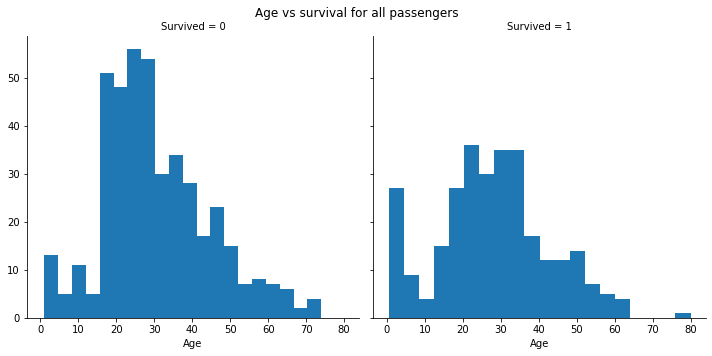

In [19]:
histogramAge = sns.FacetGrid(train, col='Survived', height=5) # create instance of FacetGrid
histogramAge.map(plt.hist, 'Age', bins=20) # map the grid to a plot in pyplot
histogramAge.fig.subplots_adjust(top=0.9)
histogramAge.fig.suptitle("Age vs survival for all passengers")
myPlot()

#### Analyse survival of passengers for each class
Can see you're more likely to not have survived if Pclass = 3 and more likely to survive if Pclass = 1

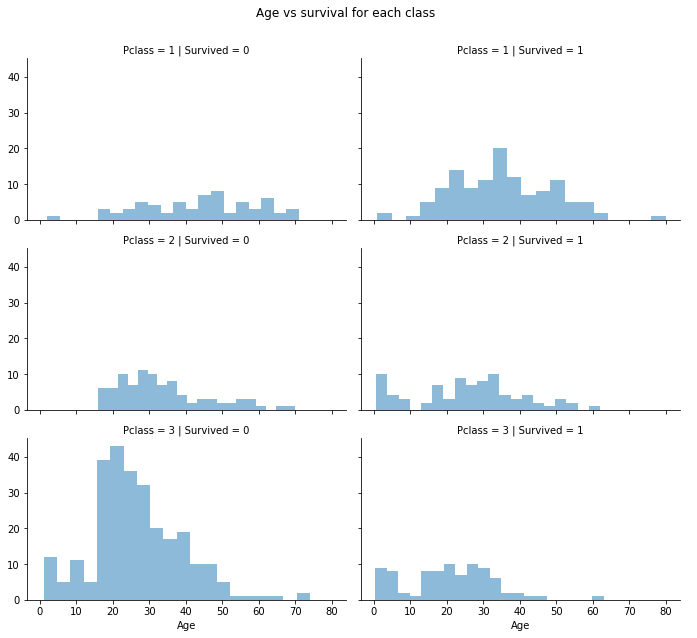

In [20]:
histogramPclassAge = sns.FacetGrid(train, col='Survived', row='Pclass', height=3, aspect=1.6)
histogramPclassAge.map(plt.hist, 'Age', alpha = 0.5, bins = 20)
histogramPclassAge.add_legend()
histogramPclassAge.fig.subplots_adjust(top=0.9)
histogramPclassAge.fig.suptitle("Age vs survival for each class")
myPlot()

### Analyse passenger sex and age
Conclude that you were much less likely to survive as a young male and more likely to survive as a woman 

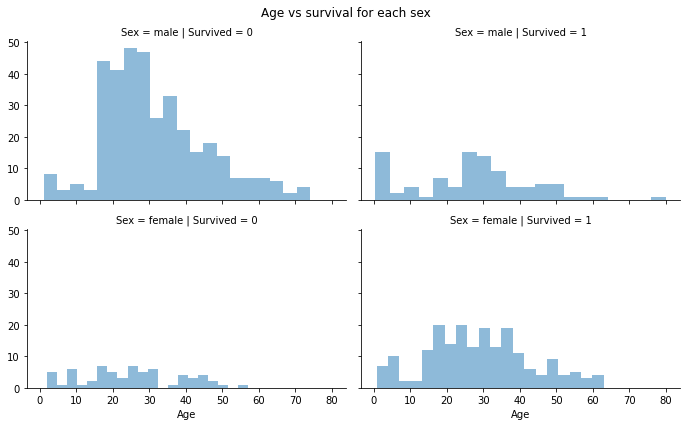

In [21]:
histogramPclassAge = sns.FacetGrid(train, col = 'Survived', row = 'Sex', height = 3, aspect = 1.6)
histogramPclassAge.map(plt.hist, 'Age', alpha = 0.5, bins = 20)
histogramPclassAge.add_legend()
histogramPclassAge.fig.subplots_adjust(top=0.9)
histogramPclassAge.fig.suptitle("Age vs survival for each sex")
myPlot()

#### Analyse Embarking point and survival

Instead of a bar chart, look at a pointplot which shows the mean value with an error bar. 
Find that females more likely to survive if boarding at S and Q ports, males at C port.
For Pclass = 3, survival of male and females closer than other classes.
Note that in the plot, have some data with only a few points, e.g, only two females (both survived) and one male (died) boarded at Q from Pclass = 2, and one male (died) and female (survived) from Pclass = 1.

In [22]:
## Below looking at issue with swapped colours in seaborn plot
myPrint(train[(train['Embarked'] == 'C') & (train['Sex'] == 'male') & (train['Pclass'] == 2)][['Sex', 'Survived', 'Pclass', 'Embarked']].head(20), printmessage="Pclass2, Male, C")
myPrint(train[(train['Embarked'] == 'C') & (train['Sex'] == 'female') & (train['Pclass'] == 2)][['Sex', 'Survived', 'Pclass', 'Embarked']].head(10), "Pclass2, Female, C")

myPrint(train[(train['Embarked'] == 'C') & (train['Sex'] == 'male') & (train['Pclass'] == 1)][['Sex', 'Survived', 'Pclass', 'Embarked']].head(20), "Pclass1, Male, C")
myPrint(train[(train['Embarked'] == 'C') & (train['Sex'] == 'female') & (train['Pclass'] == 1)][['Sex', 'Survived', 'Pclass', 'Embarked']].head(10), "Pclass1, Female, C")

myPrint(train[(train['Embarked'] == 'C') & (train['Sex'] == 'male') & (train['Pclass'] == 3)][['Sex', 'Survived', 'Pclass', 'Embarked']].head(20), "Pclass3, Male, C")
myPrint(train[(train['Embarked'] == 'C') & (train['Sex'] == 'female') & (train['Pclass'] == 3)][['Sex', 'Survived', 'Pclass', 'Embarked']].head(10), "Pclass3, Female, C")

____________________ Pclass2, Male, C ____________________
      Sex  Survived  Pclass Embarked
122  male         0       2        C
135  male         0       2        C
181  male         0       2        C
292  male         0       2        C
308  male         0       2        C
361  male         0       2        C
547  male         1       2        C
685  male         0       2        C
817  male         0       2        C
827  male         1       2        C
Press any button to continue.
        Sex  Survived  Pclass Embarked
9    female         1       2        C
43   female         1       2        C
389  female         1       2        C
473  female         1       2        C
608  female         1       2        C
866  female         1       2        C
874  female         1       2        CPclass2, Female, C
Press any button to continue.
      Sex  Survived  Pclass Embarked
30   male         0       1        C
34   male         0       1        C
54   male         0       1      

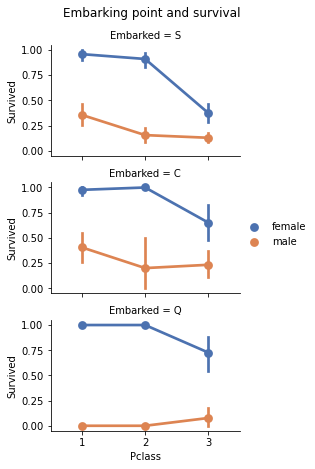

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Fare, Embarked, TicketPrefix, TicketNumber, CabinPrefix, CabinNumber]
Index: []


In [23]:
lineplotEmbarkedPclass = sns.FacetGrid(train, row = 'Embarked', height = 2.2, aspect = 1.6)
lineplotEmbarkedPclass.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = 'deep', split=True, order=[1,2,3], hue_order=['female','male'])
lineplotEmbarkedPclass.add_legend()
lineplotEmbarkedPclass.fig.subplots_adjust(top=0.9)
lineplotEmbarkedPclass.fig.suptitle("Embarking point and survival")
myPlot()

#dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j + 1)]['Age']
myPrint(train[(train['Embarked'] == 'C') & train['Sex'] == 'Male'].head(), hold=False)

#### Analyse Fare vs Embarkment and Fare vs Sex
Find that those who embarked at Q paid a lower fare and had equal liklihood of suriviving and not surviving.
Those who embarked at C and S were more likely to survive if their fare was higher.

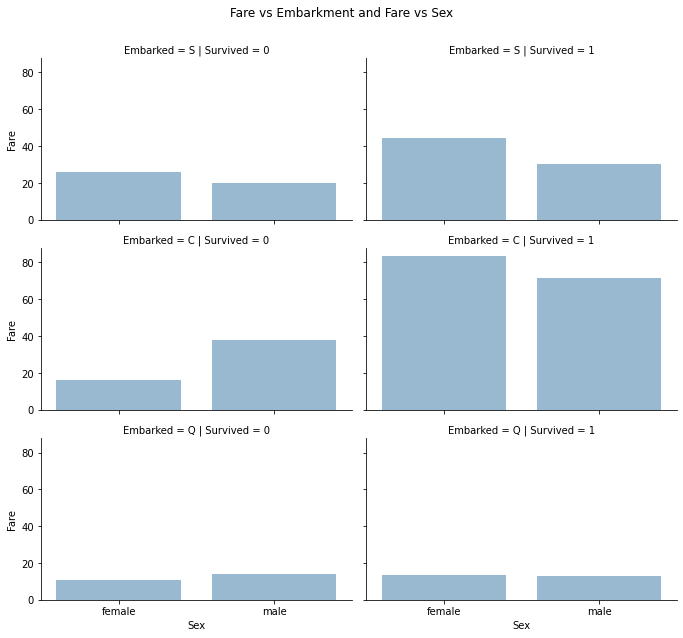

In [24]:
histogramFareEmbarkSex = sns.FacetGrid(train, row = 'Embarked', col = 'Survived', height = 3, aspect = 1.6)
histogramFareEmbarkSex.map(sns.barplot, 'Sex', 'Fare', alpha = 0.5, ci = None, order=['female','male'])
histogramFareEmbarkSex.fig.subplots_adjust(top=0.9)
plt.suptitle("Fare vs Embarkment and Fare vs Sex")
myPlot()

### - Feature engineering - 

#### First we drop the ticket and cabin features as these aren't useful
The cabin features aren't useful because there are so many missing entries.
The ticket feature we found didn't correlate with survival.

In [25]:
newtotal = list(map(lambda x: x.drop(['TicketPrefix', 'TicketNumber','CabinPrefix', 'CabinNumber'], axis = 1), total))

#### Create 'Title' feature from the names and titles

In [26]:
## First extract the titles
for dataset in newtotal:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
myPrint(pd.crosstab(newtotal[0]['Title'], newtotal[0]['Sex']), hold=False)

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [27]:
## Take rare title and combine into one category. Also replace Ms with Miss and Mme with Mrs
for dataset in newtotal:
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')

In [28]:
## Calculate the mean survival rate for each title
myPrint(newtotal[0][['Title', 'Survived']].groupby(['Title'], as_index = False).mean(),
        printmessage="Mean Survival", hold=False)

____________________ Mean Survival ____________________
    Title  Survived
0  Master  0.575000
1    Miss  0.699454
2    Mlle  1.000000
3      Mr  0.156673
4     Mrs  0.793651
5    Rare  0.347826


In [29]:
## Now map the titles to numbers
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
for dataset in newtotal:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0) # fill any missing entries with 0
    dataset['Title'] = dataset['Title'].astype(int) # set type as int
myPrint(newtotal[0].head(), hold=False)

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch     Fare Embarked  Title  
0      0   7.2500        S      1  
1      0  71.2833        C      3  
2      0   7.9250        S      2  
3      0  53.1000        S      3  
4      0   8.0500        S      1  


In [30]:
## Drop the name feature now the title feature created
newtotal2 = list(map(lambda x: x.drop(['Name', 'PassengerId'], axis = 1), newtotal))

#### Creating Sex feature. 

In [31]:
sex_mapping = {'female': 1, 'male': 0}
for dataset in newtotal2:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping).astype(int)
myPrint(newtotal2[0].head(), hold=False)

   Survived  Pclass  Sex   Age  SibSp  Parch     Fare Embarked  Title
0         0       3    0  22.0      1      0   7.2500        S      1
1         1       1    1  38.0      1      0  71.2833        C      3
2         1       3    1  26.0      0      0   7.9250        S      2
3         1       1    1  35.0      1      0  53.1000        S      3
4         0       3    0  35.0      0      0   8.0500        S      1


#### Creating Age feature

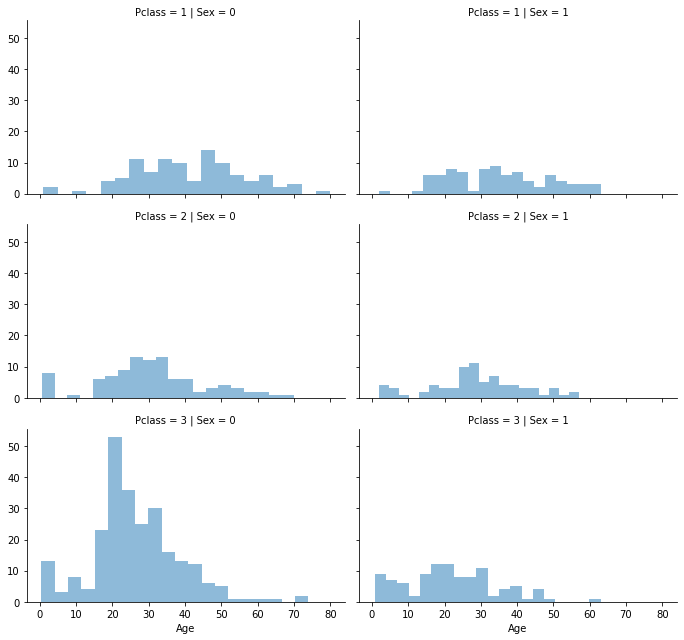

In [32]:
## Complete missing Age data -- First look at age data
ageGrid = sns.FacetGrid(newtotal2[0], row='Pclass', col='Sex', height=3, aspect=1.6)
ageGrid.map(plt.hist, 'Age', alpha=0.5, bins=20)
myPlot()

In [33]:
## Now interpolate ages for missing values. 
## This is done either by replacing the age by the median for a given sex or by sampling from a uniform distribution 
## using the mean and std of the sex and Pclassfor dataset in newtotal2:
for dataset in newtotal2:
    for i in range(0,2): ## only two sex values - 0 and 1
        for j in range(0,3): ## only 3 class values - 1, 2, 3 (add a 1 to value later)

            ## Obtain the data with the corresponding sex and class. 
            ## Remove missing values to calculate the mean and standard deviation (std).
            guess = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j + 1)]['Age'].dropna() 
           
            ## Fill in any missing values using an age guess from a random distribution with a mean and std from the data
            ## Note that rather than guessing from a random distribution using the mean and std from all ages,
            ## we instead use the mean and std from each Sex and Pclass
            age_guess = rnd.uniform((guess.mean()-guess.std()),(guess.mean() + guess.std()))

            ## Round age to nearest half a year
            guess_val = int(age_guess/0.5 + 0.5)*0.5
            print(i, " ", j, " ", guess_val)

            ## Replace age with guess value if null entry
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), 'Age'] = guess_val
    
    ## Convert ages to integer values
    dataset['Age'] = dataset['Age'].astype(int)

0   0   30.0
0   1   21.0
0   2   30.0
1   0   43.0
1   1   19.0
1   2   34.5
0   0   43.0
0   1   30.5
0   2   22.5
1   0   28.0
1   1   23.0
1   2   27.5


In [34]:
## Split data into age bands and check survival based on bands
train_ageband = newtotal2[0].copy()
train_ageband['AgeBand'] = pd.cut(train_ageband['Age'], 5)
myPrint(train_ageband[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index = False).mean().sort_values(by = 'AgeBand', ascending = True),
        hold=False)

         AgeBand  Survived
0  (-0.08, 16.0]  0.550000
1   (16.0, 32.0]  0.310127
2   (32.0, 48.0]  0.459916
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


In [35]:
## Split the total dataset into bands and then assign numerical values to each band
for dataset in newtotal2:
    dataset.loc[(dataset['Age'] <= 16), 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 64), 'Age'] = 4
    
newtotal3 = newtotal2

#### Create new Alone Feature

In [49]:
## Create new FamilySize feature by adding siblings and parents together to person value (hence +1)
## Then create Alone feature if FamilySize = 1
for dataset in newtotal3:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['Alone'] = 0 # first create the alone feature with a zero value
    dataset.loc[dataset['FamilySize'] == 1, 'Alone'] = 1 # then assign to it a value of 1 if a person is alone, 0 if not

In [50]:
myPrint(newtotal3[0][['FamilySize', 'Survived']].groupby(['FamilySize'], as_index = False).mean().sort_values(by = 'Survived', ascending = False),
         hold=False)
myPrint(newtotal3[0][['Alone', 'Survived']].groupby(['Alone'], as_index = False).mean(),  
        hold=False)

   FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.000000
8          11  0.000000
   Alone  Survived
0      0  0.505650
1      1  0.303538


In [51]:
## Remove the 'FamilySize', 'Parch' and 'SibSp' features
newtotal4 = list(map(lambda x: x.drop(['Parch', 'SibSp', 'FamilySize'], axis = 1), newtotal3))
myPrint(newtotal4[0].head(), hold=False)

   Survived  Pclass  Sex  Age     Fare Embarked  Title  Alone
0         0       3    0    1   7.2500        S      1      0
1         1       1    1    2  71.2833        C      3      0
2         1       3    1    1   7.9250        S      2      1
3         1       1    1    2  53.1000        S      3      0
4         0       3    0    2   8.0500        S      1      1


#### Complete the Embark feature

In [37]:
## Find the most common value of the embark feature and use this to fill missing values
freq_port = newtotal4[0].Embarked.dropna().mode()[0]
for dataset in newtotal4:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
myPrint(newtotal4[0][['Embarked', 'Survived']].groupby(['Embarked'], as_index = False).mean().sort_values(by = 'Survived', ascending = False),
         hold=False)

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


In [38]:
## Map the embark feature to a numerical value
embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
for dataset in newtotal4:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)
myPrint(newtotal4[0].head(), hold=False)

   Survived  Pclass  Sex  Age     Fare  Embarked  Title  Alone
0         0       3    0    1   7.2500         0      1      0
1         1       1    1    2  71.2833         1      3      0
2         1       3    1    1   7.9250         0      2      1
3         1       1    1    2  53.1000         0      3      0
4         0       3    0    2   8.0500         0      1      1


#### Complete the Fare feature

In [39]:
## Fill missing values with the median Fare value
for dataset in newtotal4:
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].dropna().median())
myPrint(newtotal4[0].head(), hold=False)

   Survived  Pclass  Sex  Age     Fare  Embarked  Title  Alone
0         0       3    0    1   7.2500         0      1      0
1         1       1    1    2  71.2833         1      3      0
2         1       3    1    1   7.9250         0      2      1
3         1       1    1    2  53.1000         0      3      0
4         0       3    0    2   8.0500         0      1      1


In [40]:
## Create Fare band and convert to numerical values - first look at bands and survival rates
train_testband = newtotal4[0].copy()
train_testband['Fareband'] = pd.qcut(train_testband['Fare'], 4)
myPrint(train_testband[['Fareband', 'Survived']].groupby(['Fareband'], as_index = False).mean().sort_values(by = 'Fareband', ascending = True),
         hold=False)

          Fareband  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


In [41]:
## Create the fare bands and map to numerical values
for dataset in newtotal4:
    dataset.loc[(dataset['Fare'] <= 7.91), 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 31), 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

newtotal5 = newtotal4

In [42]:
myPrint(newtotal5[0].head(), hold=False)
myPrint(newtotal5[1].head(), hold=False)

   Survived  Pclass  Sex  Age  Fare  Embarked  Title  Alone
0         0       3    0    1     0         0      1      0
1         1       1    1    2     3         1      3      0
2         1       3    1    1     1         0      2      1
3         1       1    1    2     3         0      3      0
4         0       3    0    2     1         0      1      1
   Pclass  Sex  Age  Fare  Embarked  Title  Alone
0       3    0    2     0         2      1      1
1       3    1    2     0         0      3      0
2       2    0    3     1         2      1      1
3       3    0    1     1         0      1      1
4       3    1    1     1         0      3      0


### - Train the model - 

#### Remove the labels from the train dataset

In [43]:
X_train = newtotal5[0].drop('Survived', axis = 1)
Y_train = newtotal5[0]['Survived']
X_test = newtotal5[1]

#### Build the model

In [44]:
modelType = 'RandomForest'

if modelType == 'RandomForest':
    ## Use Random Forest for training model
    model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=2)
elif modelType == 'XGBoost':
    ## Use XGBoost for training model
    model = xgb.XGBRegressor(objective="binary:logistic", random_state=42)
else:
    myPrint("Model not chosen")
    sys.exit()

#### Fit the model

In [45]:
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=3, random_state=2)

#### Predicted output

In [46]:
Y_pred = model.predict(X_test)
predictions = [round(value) for value in Y_pred]

#### Assesment of model

In [47]:
Y_pred_train = model.predict(X_train)
predictions_train = [round(value) for value in Y_pred_train]
score = accuracy_score(Y_train, predictions_train)

accuracy_model = round(score*100,2)
myPrint(accuracy_model, hold=False)

79.91


### - Create a submission file for the Kaggle competition -

In [48]:
## Entries are passenger ID and if they survived (0/1 for deceased/survived)
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })
submission.to_csv('submission.csv', index=False)